<a href="https://colab.research.google.com/github/jiteshpabla/Meal-Detection-using-CGM-data-/blob/main/Meal_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports

In [ ]:
!cp -r "gdrive/My Drive/sem3/DM/ass1/" .

cp: cannot open 'gdrive/My Drive/sem3/DM/ass1/CGMData.gsheet' for reading: Operation not supported
cp: cannot open 'gdrive/My Drive/sem3/DM/ass1/InsulinData.gsheet' for reading: Operation not supported
cp: cannot open 'gdrive/My Drive/sem3/DM/ass1/Results.gsheet' for reading: Operation not supported


In [ ]:
import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

# Load and Clean data; find split

In [ ]:
df_cgm = pd.read_csv("ass1/CGMData.csv")
df_cgm = df_cgm.dropna(axis='columns', how="all")
#df_cgm

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_insulin = pd.read_csv("ass1/InsulinData.csv")
df_insulin = df_insulin.dropna(axis='columns', how="all")
#df_insulin

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#get the last row, ie, chonologically first
split_point = df_insulin.query("Alarm == 'AUTO MODE ACTIVE PLGM OFF'").iloc[-1]

In [ ]:
# SPLIT point
#so the date is 8/9/2017 and time 8:07:13; EARLIEST DATE
split_date = split_point["Date"]  #("2017-08-09")
split_time = split_point["Time"]  #("08:07:13")
print("auto/manual split point:", split_date, split_time)

auto/manual split point: 8/9/2017 8:07:13


In [ ]:
df_cgm['Date']= pd.to_datetime(df_cgm['Date']) 
df_cgm['Time']= pd.to_datetime(df_cgm['Time']) 

In [ ]:
#check to see if datatype conversion was successful
#df_cgm.info()

# Split data (auto and manual)

In [ ]:
df_index = df_cgm.query("Date == '"+split_date+"' and Time >= '"+split_time+"'")
df_index = df_index[df_index["Time"] == df_index["Time"].min()]
df_index

,Index,Date,Time,Sensor Glucose (mg/dL),ISIG Value,Event Marker,Sensor Exception
51086,48603,2017-08-09,2020-09-15 08:10:05,173.0,32.03,NaN,NaN


In [ ]:
#index is <=50972 for manual mode
split_index = df_index.index[0]
print("auto/manual split point index:",split_index)

auto/manual split point index: 51086


In [ ]:
def day_night_split(df):
  df_daysOnly = df.query("Time >= '06:00:00'")
  df_nightsOnly = df.query("Time >= '00:00:00' and Time <= '05:59:59'")
  return df_daysOnly, df_nightsOnly

## automode explore

In [ ]:
print("-------- AUTOMODE ---------")

-------- AUTOMODE ---------


In [ ]:
df_auto = df_cgm[:split_index]
#print(len(df_auto))

In [ ]:
print("---interpolation---")

---interpolation---


In [ ]:
import copy
def interpolate_data(df, name, inter_type="linear"):
  s = pd.Series(df["Sensor Glucose (mg/dL)"])
  #s.plot(figsize=(50,10))
  print(name, " NaN VALUES :", s.isna().sum())
  
  ss = copy.deepcopy(s)
  #s =s.interpolate(method='polynomial', order=10)
  ss =ss.interpolate(method=inter_type)
  ss.plot(figsize=(50,10))

  df_inter = df.copy()
  df_inter["Sensor Glucose (mg/dL)"] = ss

  print(name, "rows after interpolation", len(df_inter))
  return df_inter

automode  NaN VALUES : 3806
automode rows after interpolation 51086


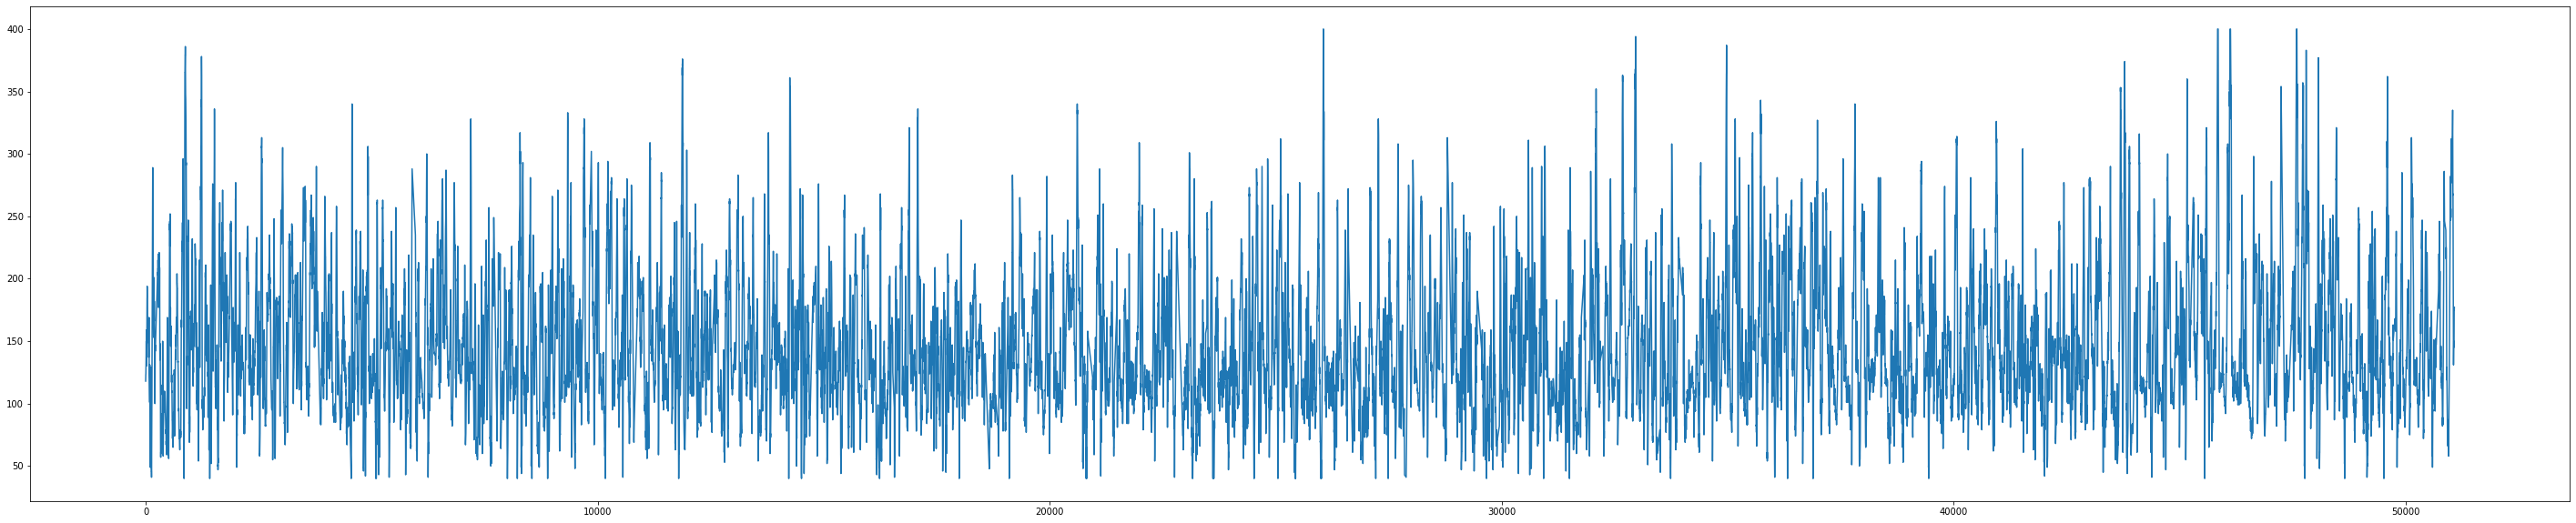

In [ ]:
df_inter_auto = interpolate_data(df_auto, "automode")

In [ ]:
#day night values
df_inter_auto_daysOnly, df_inter_auto_nightsOnly = day_night_split(df_inter_auto)
print("day, night, full splits :", len(df_inter_auto_daysOnly), len(df_inter_auto_nightsOnly), len(df_inter_auto))

day, night, full splits : 38264 12822 51086


## manual mode explore

In [ ]:
print("-------- MANUALMODE ---------")

-------- MANUALMODE ---------


In [ ]:
df_manual = df_cgm[split_index:]
#print(len(df_manual))

#### interpolation

In [ ]:
print("---interpolation---")

---interpolation---


manual  NaN VALUES : 362
manual rows after interpolation 4257


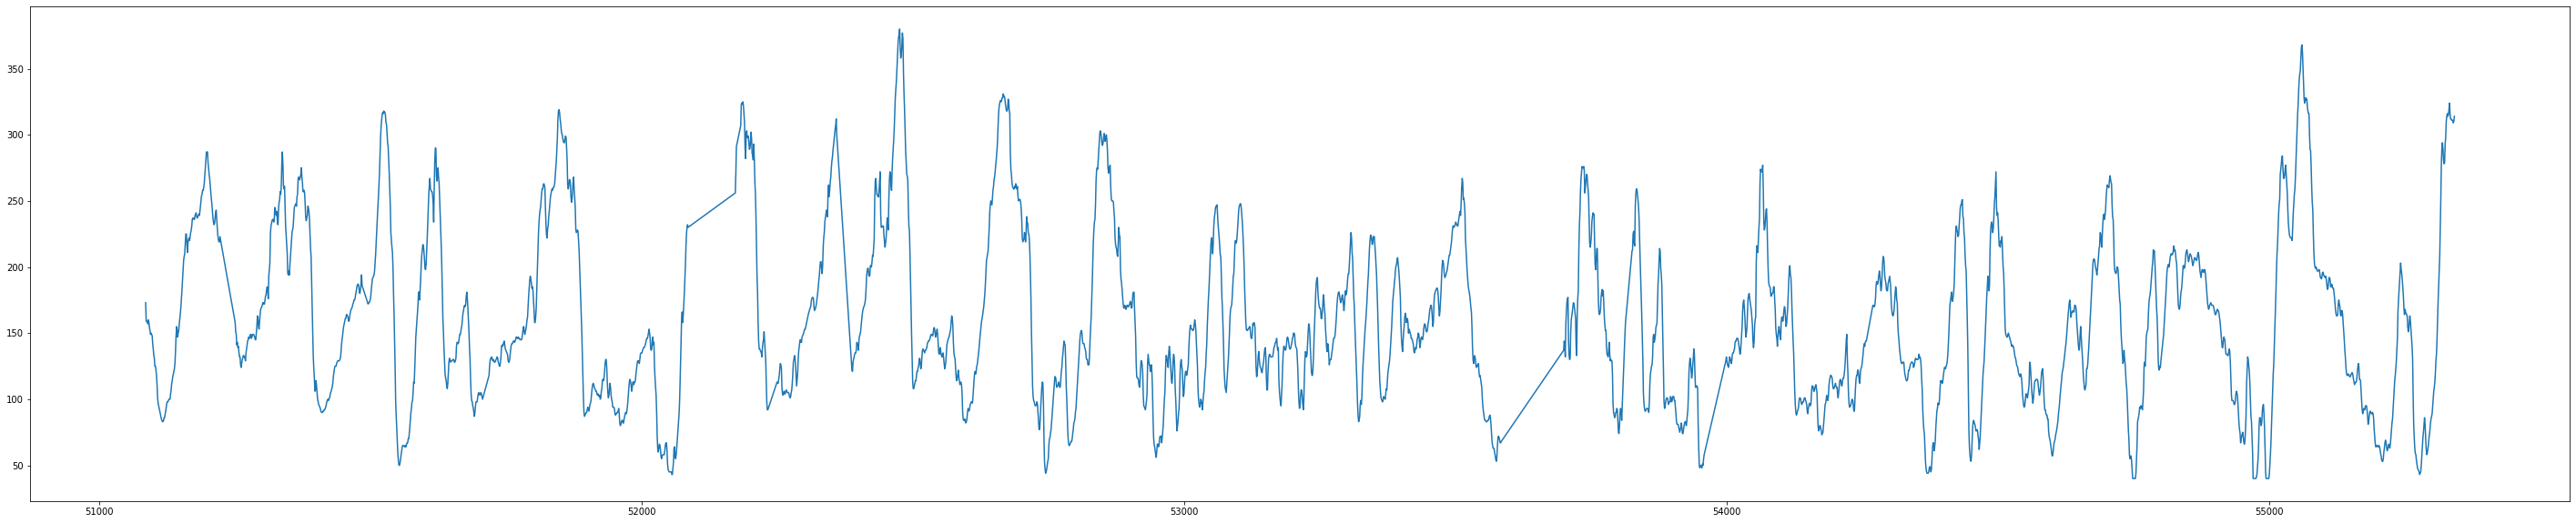

In [ ]:
df_inter_manual = interpolate_data(df_manual, "manual")

In [ ]:
#day night values
df_inter_manual_daysOnly, df_inter_manual_nightsOnly = day_night_split(df_inter_manual)
print("day, night, full splits: ", len(df_inter_manual_daysOnly), len(df_inter_manual_nightsOnly), len(df_inter_manual))

day, night, full splits:  3177 1080 4257


# Metrics (with linear interpolation)

In [ ]:
def count_days(df):
  days = len(df.groupby(['Date']).count())
  print("days:", days)
  return days

In [ ]:
def calc_percentage_time(df, days, lower_bound= ">0.0", upper_bound = "<1000000.0"):
  print("---")
  df = df.query("`Sensor Glucose (mg/dL)`" + lower_bound + " and `Sensor Glucose (mg/dL)` " + upper_bound)
  numer = len(df)
  denom = (288*days)
  final_val = 0.0
  if denom:
    final_val = numer/denom
  
  print("sum of all counts, 288*num of days, division",numer, denom, final_val)
  return final_val*100

In [ ]:
def append_to_matrix(df, days, row, matrix):
  print("--------")
  matrix[row].append(calc_percentage_time(df, days, ">180.0"))
  matrix[row].append(calc_percentage_time(df, days, ">250.0"))
  matrix[row].append(calc_percentage_time(df, days, ">=70.0", "<=180"))
  matrix[row].append(calc_percentage_time(df, days, ">=70.0", "<=150"))
  matrix[row].append(calc_percentage_time(df, days, ">=0.0", "<70"))
  matrix[row].append(calc_percentage_time(df, days, ">=0.0", "<54"))

In [ ]:
matrix_inter = [[], []]

In [ ]:
# % for all data points
days_inter_manual = count_days(df_inter_manual)
print("for entire manualmode:")
calc_percentage_time(df_inter_manual, days_inter_manual)

days: 16
for entire manualmode:
---
sum of all counts, 288*num of days, division 4257 4608 0.923828125


92.3828125

In [ ]:
# manual
append_to_matrix(df_inter_manual_nightsOnly, days_inter_manual, 0, matrix_inter)
append_to_matrix(df_inter_manual_daysOnly, days_inter_manual, 0, matrix_inter)
append_to_matrix(df_inter_manual, days_inter_manual, 0, matrix_inter)

--------
---
sum of all counts, 288*num of days, division 211 4608 0.04578993055555555
---
sum of all counts, 288*num of days, division 45 4608 0.009765625
---
sum of all counts, 288*num of days, division 840 4608 0.18229166666666666
---
sum of all counts, 288*num of days, division 625 4608 0.13563368055555555
---
sum of all counts, 288*num of days, division 29 4608 0.006293402777777778
---
sum of all counts, 288*num of days, division 0 4608 0.0
--------
---
sum of all counts, 288*num of days, division 1191 4608 0.2584635416666667
---
sum of all counts, 288*num of days, division 424 4608 0.0920138888888889
---
sum of all counts, 288*num of days, division 1766 4608 0.3832465277777778
---
sum of all counts, 288*num of days, division 1380 4608 0.2994791666666667
---
sum of all counts, 288*num of days, division 220 4608 0.04774305555555555
---
sum of all counts, 288*num of days, division 83 4608 0.018012152777777776
--------
---
sum of all counts, 288*num of days, division 1402 4608 0.3042

In [ ]:
# % for all data points
days_inter_auto = count_days(df_inter_auto)
print("for entire automode:")
calc_percentage_time(df_inter_auto, days_inter_auto)

days: 180
for entire automode:
---
sum of all counts, 288*num of days, division 51086 51840 0.9854552469135802


98.54552469135803

In [ ]:
# auto
append_to_matrix(df_inter_auto_nightsOnly, days_inter_auto, 1, matrix_inter)
append_to_matrix(df_inter_auto_daysOnly, days_inter_auto, 1, matrix_inter)
append_to_matrix(df_inter_auto, days_inter_auto, 1, matrix_inter)

--------
---
sum of all counts, 288*num of days, division 1509 51840 0.029108796296296296
---
sum of all counts, 288*num of days, division 237 51840 0.004571759259259259
---
sum of all counts, 288*num of days, division 10966 51840 0.2115354938271605
---
sum of all counts, 288*num of days, division 9576 51840 0.18472222222222223
---
sum of all counts, 288*num of days, division 347 51840 0.006693672839506173
---
sum of all counts, 288*num of days, division 102 51840 0.0019675925925925924
--------
---
sum of all counts, 288*num of days, division 11033 51840 0.21282793209876544
---
sum of all counts, 288*num of days, division 2546 51840 0.04911265432098765
---
sum of all counts, 288*num of days, division 25374 51840 0.4894675925925926
---
sum of all counts, 288*num of days, division 18906 51840 0.3646990740740741
---
sum of all counts, 288*num of days, division 1857 51840 0.03582175925925926
---
sum of all counts, 288*num of days, division 554 51840 0.010686728395061728
--------
---
sum of

In [ ]:
# final values

In [ ]:
print(matrix_inter[0])

[4.578993055555555, 0.9765625, 18.229166666666664, 13.563368055555555, 0.6293402777777778, 0.0, 25.846354166666668, 9.20138888888889, 38.32465277777778, 29.947916666666668, 4.774305555555555, 1.8012152777777777, 30.42534722222222, 10.17795138888889, 56.55381944444444, 43.51128472222222, 5.403645833333334, 1.8012152777777777]


In [ ]:
print(matrix_inter[1])

[2.9108796296296298, 0.4571759259259259, 21.15354938271605, 18.47222222222222, 0.6693672839506173, 0.19675925925925924, 21.282793209876544, 4.911265432098765, 48.94675925925926, 36.46990740740741, 3.582175925925926, 1.0686728395061729, 24.19367283950617, 5.3684413580246915, 70.1003086419753, 54.94212962962963, 4.2515432098765435, 1.2654320987654322]


In [ ]:
final_results = pd.DataFrame(matrix_inter)
final_results.to_csv("Results_Interpolation.csv")